# Testing QSAR of Targets

In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Picking a target.

In [2]:
import os

dockstring_dir = f'{path}/dockstring_targets/'
files = os.listdir(dockstring_dir)
configs = sorted([f for f in files if 'conf' in f])
targets = sorted([f for f in files if 'target' in f])

idx = 30
with open(dockstring_dir + configs[idx], 'r') as f:
    config_ = f.readlines()
    config_ = [c.replace('\n', '') for c in config_]
    config_ = [c.split(' = ') for c in config_ if c]
    config_ = {c[0]: float(c[1]) for c in config_}

target = targets[idx]
name = target.split('_')[0]

config_.update({
    'size_x': 15,
    'size_y': 15,
    'size_z': 15,
})

Docking.

In [3]:
from dgym.envs.oracle import DockingOracle, NeuralOracle, NoisyOracle
from dgym.envs.utility import ClassicUtilityFunction

config = {
    'search_mode': 'balanced',
    'scoring': 'gnina',
    'seed': 5,
    **config_
}

# Create noiseless evaluators
docking_oracle = DockingOracle(
    f'{name} affinity',
    receptor_path=f'{dockstring_dir}/{target}',
    config=config
)

Designer.

In [4]:
from dgym.molecule import Molecule
from dgym.envs.designer import Designer, Generator
from dgym.envs.drug_env import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy
from dgym.experiment import Experiment

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

Generate molecules.

In [5]:
from tqdm.notebook import tqdm

# select first molecule
import random
def select_molecule(deck):
    initial_index = random.randint(0, len(deck))
    initial_molecule = deck[initial_index]
    if len(initial_molecule.reactants) == 2 \
        and designer.match_reactions(initial_molecule):
        return initial_molecule
    else:
        return select_molecule(deck)

random_molecules = []
for _ in tqdm(range(20)):
    
    # pick a molecule randomly from the deck
    initial_molecule = select_molecule(deck)

    # generate a few rounds of random molecules in REAL Space
    molecule = initial_molecule
    designer.reset_cache()
    for _ in range(3):
        molecule = designer.design(molecule, 1, temperature=1.0)[0]
    
    # generate a bunch of analogs
    molecules = designer.design(molecule, 10, temperature=0.0)
    
    random_molecules.extend(molecules)

  0%|          | 0/20 [00:00<?, ?it/s]

Get results of docking.

In [6]:
import time

t = time.time()
scores = docking_oracle(random_molecules, units='pIC50')

print(time.time() - t)

114.69323182106018


/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


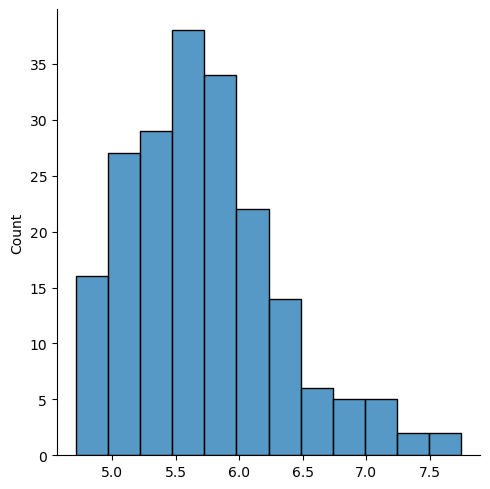

In [9]:
import seaborn as sns

sns.displot(scores)

In [ ]:
chembl_test_igf1r.csv

Look at inter- vs. intra-cluster variation.

In [59]:
import numpy as np

chunks = np.array_split(random_molecules, 20)
cluster_stds = [np.nanstd(docking_oracle(chunk)) for chunk in chunks]
mean_cluster_std = np.nanmean(cluster_stds)
mean_std = np.nanstd(scores)
print('Within Cluster:', mean_cluster_std,
      '\nBetween Cluster:', mean_std)

Within Cluster: 0.22270225152815146 
Between Cluster: 0.5928954390779667


Compare pairwise fingerprints and affinity.

In [12]:
import chemfp

self = designer.generator

fingerprint_type = self.fingerprints.get_fingerprint_type()
fingerprints = [
    (m.name, fingerprint_type.from_smi(m.smiles))
    for m in random_molecules
]

queries = chemfp.load_fingerprints(
    fingerprints,
    metadata = fingerprint_type.get_metadata(),
    reorder=False
)

results = chemfp.simsearch(
    queries=queries,
    targets=queries,
    threshold=0.0,
    include_lower_triangle=False,
)

similarity = results.to_pandas()
similarity_matrix = results.to_csr().A

queries:   0%|                            | 0/200 [00:00<?, ? fps/s]

Get affinity score differences.

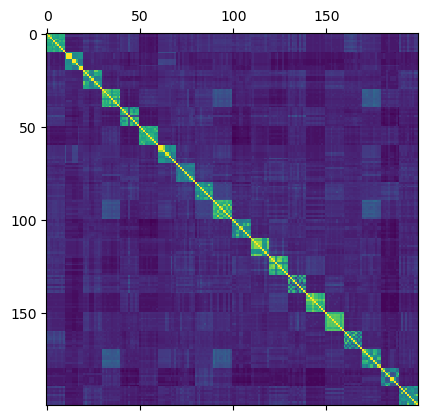

In [16]:
import numpy as np
from sklearn.metrics.pairwise import nan_euclidean_distances

# Convert the list of floats to a 2D numpy array with one column
float_array = np.array(scores).reshape(-1, 1)

# Calculate pairwise distances using the default metric (Euclidean)
distances = nan_euclidean_distances(float_array)

import matplotlib.pyplot as plt
plt.matshow(similarity_matrix)

Text(0.5, 1.0, 'Correlation of Docking and Fingerprint Similarity')

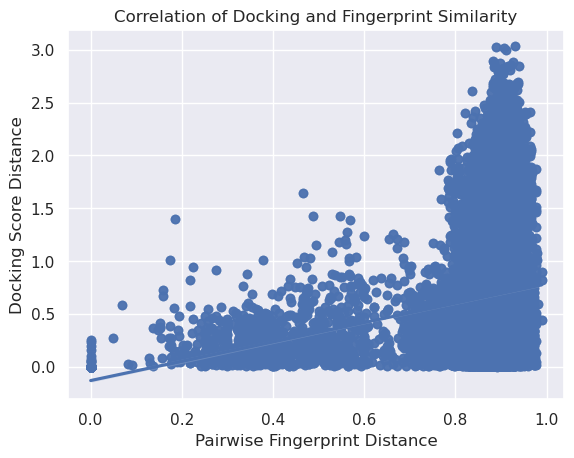

In [18]:
sns.set()
g = sns.regplot(
    x=1-similarity_matrix.ravel(),
    y=abs(distances).ravel(),
)

plt.xlabel('Pairwise Fingerprint Distance')
plt.ylabel('Docking Score Distance')
plt.title('Correlation of Docking and Fingerprint Similarity')

Seeing if being similar to high affinity molecules predicts high affinity.

In [19]:
best = np.argsort(scores)[-10:]
best_molecules = dg.collection.Collection(random_molecules)[best]

In [50]:
import chemfp

self = designer.generator

fingerprint_type = self.fingerprints.get_fingerprint_type()
fingerprints = [
    (m.name, fingerprint_type.from_smi(m.smiles))
    for m in best_molecules
]

best_queries = chemfp.load_fingerprints(
    fingerprints,
    metadata = fingerprint_type.get_metadata(),
    reorder=False
)

results = chemfp.simsearch(
    queries=best_queries,
    targets=queries,
    k=5,
    include_lower_triangle=False,
)

queries:   0%|                             | 0/10 [00:00<?, ? fps/s]

In [58]:
# mols = results.to_pandas()['target_id'].tolist()
nearest_scores = [
    scores[i]
    for index in results.iter_indices()
    for i in index
    if i not in best
]

np.nanmean(nearest_scores)

6.558572739689007

In [54]:
nearest_scores

[6.909494029869256,
 6.353862892683193,
 6.353862892683193,
 6.890764455852641,
 6.6168241884541334,
 6.28181397689544,
 6.130668644444765,
 6.909494029869256,
 6.353862892683193,
 6.740041279576081,
 6.723571164945385,
 6.5810795574698995,
 6.474604014362043,
 6.909494029869256,
 6.353862892683193,
 6.353862892683193]

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


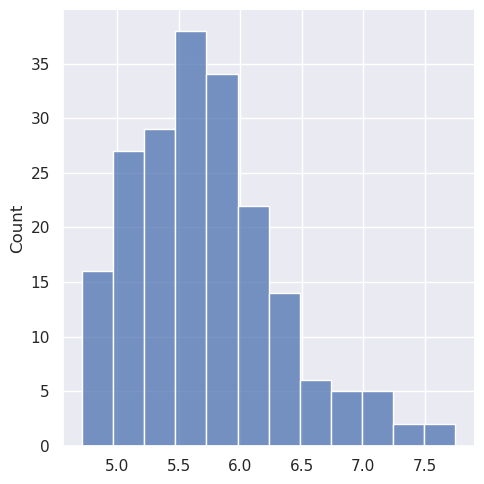

In [57]:
sns.displot(scores)

In [27]:
import seaborn as sns

sns.swarmplot(np.array(scores)[most_similar_to_best])
sns.swarmplot(np.array(scores))

NameError: name 'most_similar_to_best' is not defined